In [93]:
import pandas as pd
import numpy as np
import os
import itertools
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import networkx as nx
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # For model evaluation

cpapth = os.getcwd()

In [350]:
# https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries?select=ds_salaries.csv
salaries = pd.read_csv(r"Data/ds_salaries.csv")
salaries = salaries.drop(columns=["Unnamed: 0", "work_year", "employment_type",
                                  "salary", "salary_currency",])#.sample(n=100, random_state=32)
salaries

,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,MI,Data Scientist,79833,DE,0,DE,L
1,SE,Machine Learning Scientist,260000,JP,0,JP,S
2,SE,Big Data Engineer,109024,GB,50,GB,M
3,MI,Product Data Analyst,20000,HN,0,HN,S
4,SE,Machine Learning Engineer,150000,US,50,US,L
...,...,...,...,...,...,...,...
602,SE,Data Engineer,154000,US,100,US,M
603,SE,Data Engineer,126000,US,100,US,M
604,SE,Data Analyst,129000,US,0,US,M
605,SE,Data Analyst,150000,US,100,US,M


### Manipulate Data:

,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,MI,Data Scientist,-0.457904,DE,0,DE,L
1,SE,Machine Learning Scientist,2.083282,JP,0,JP,S
2,SE,Big Data Engineer,-0.046177,GB,50,GB,M
4,SE,Machine Learning Engineer,0.531774,US,50,US,L
10,EN,Data Scientist,-0.860055,FR,0,FR,S
...,...,...,...,...,...,...,...
591,SE,Data Architect,0.459192,US,100,US,M
594,SE,Data Analytics Manager,0.535441,US,100,US,M
600,EN,Data Analyst,-0.638909,CA,0,CA,M
601,EN,Data Analyst,-0.850478,CA,0,CA,M


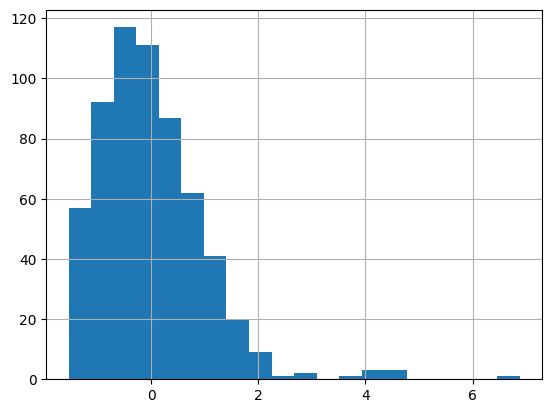

In [351]:
scaler = StandardScaler()
salaries['salary_in_usd'] = scaler.fit_transform(salaries[['salary_in_usd']]) #maybe log?
salaries.salary_in_usd.hist(bins = 20)

# Omit countries with low frequency observations 
class_counts = salaries['employee_residence'].value_counts()
salaries = salaries[salaries['employee_residence'].isin(class_counts[class_counts >= 7].index)]


# Omit 100 random us citizens for better group balance 
condition = (salaries['employee_residence'] == "US")
indices_to_remove = salaries[condition].index
indices_to_remove_random = np.random.choice(indices_to_remove, size=282, replace=False)
salaries = salaries.drop(indices_to_remove_random)
salaries


In [352]:
salaries.employee_residence.value_counts()#.plot(kind= "bar")

employee_residence
US    50
GB    44
IN    30
CA    29
DE    25
FR    18
ES    15
GR    13
JP     7
Name: count, dtype: int64

#### Connenction Permutation 

\begin{equation}
C(n, 2) = \frac{{n \cdot (n - 1)}}{2}
\end{equation}
possible Connections

In [353]:
n_permutes = lambda n : int((n * (n-1)) / 2)
print(n_permutes(salaries.shape[0]))

26565


In [354]:
idx_pairs = list(itertools.combinations(salaries.index, 2))

salary_pairs = list(itertools.combinations(salaries.salary_in_usd, 2))
salary_delta = [abs(pair[0] - pair[1]) for pair in salary_pairs]

residence_pairs = list(itertools.combinations(salaries.employee_residence, 2))
fellow_country = [int(pair[0] == pair[1] )for pair in residence_pairs]

experience_pairs = list(itertools.combinations(salaries.experience_level, 2))
same_experience = [int(pair[0] == pair[1] )for pair in experience_pairs]

title_pairs = list(itertools.combinations(salaries.job_title, 2))
same_title = [int(pair[0] == pair[1] )for pair in title_pairs]

df = pd.DataFrame({'idx': idx_pairs, 
                   'wage_delta': salary_delta,
                   'fellow_country': fellow_country, 
                   'same_title': same_title, 
                   'same_experience': same_experience
                   })

Generate Conditional Probabilities based on similarity of observations. 

\begin{equation}
P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_{1}x_{1} + \beta_{2}x_{2} + \ldots + \beta_nx_n)}}
\end{equation}

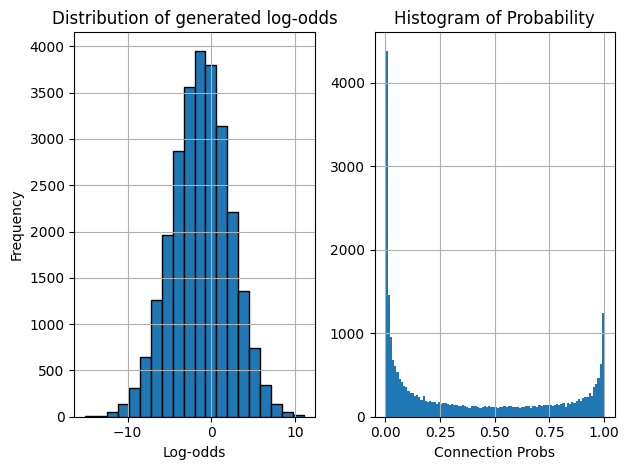

In [355]:
np.random.seed(26)
# A low negative intercept means a low default connection probability (all else = 0)
# Pushing it extremely low, will cause no connections 
beta_0 = 0 
# Coefficient for countrymen, 1 -> making it more likely to connect 
beta_cm = np.log(6)  # increase the odds-ratio by _(whats inside the log)
# Coefficient for wagedelta: the larger the gap, the less likely a connection happens 
beta_wd = -2.05 
# Coefficient for same experience: 1 -> making it more likely to connect 
beta_exper = np.log(2.2) 

beta_ti = np.log(1.6) 

log_odds = (beta_0 +
            beta_cm * df.fellow_country + 
            beta_wd * df.wage_delta +
            beta_ti * df.same_title +
            beta_exper * df.same_experience +
            np.random.normal(0,3,df.shape[0])) 
# Changes shape of distribution, larger variance -> clearer bounds
# Can break indented structure harshly when too high 

df["Connection_Prob"] = 1 / (1 + np.exp(-log_odds))

plt.subplot(1, 2, 1)
plt.hist(log_odds, bins= 20, edgecolor='black')
plt.title("Distribution of generated log-odds")
plt.xlabel('Log-odds')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
df["Connection_Prob"].hist(bins=100)
plt.title('Histogram of Probability')
plt.xlabel('Connection Probs')

plt.tight_layout()
plt.show()

<Axes: xlabel='wage_delta', ylabel='Connection_Prob'>

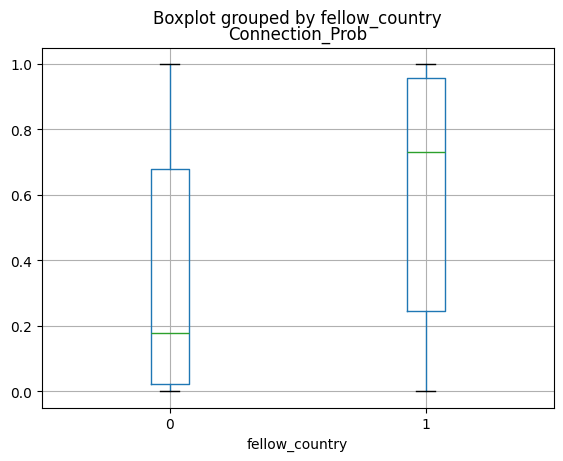

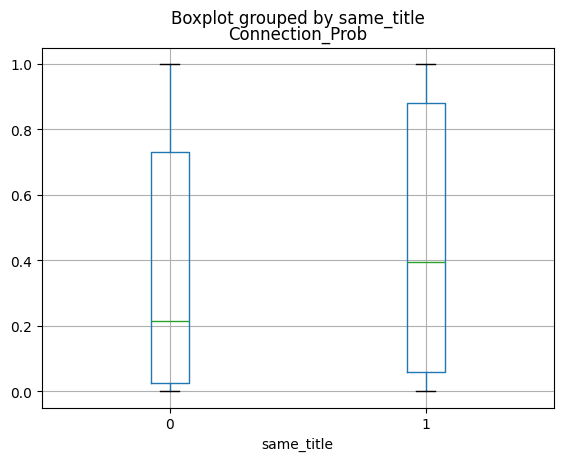

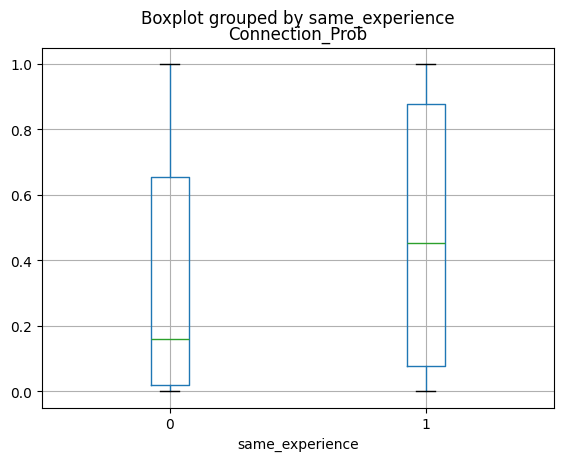

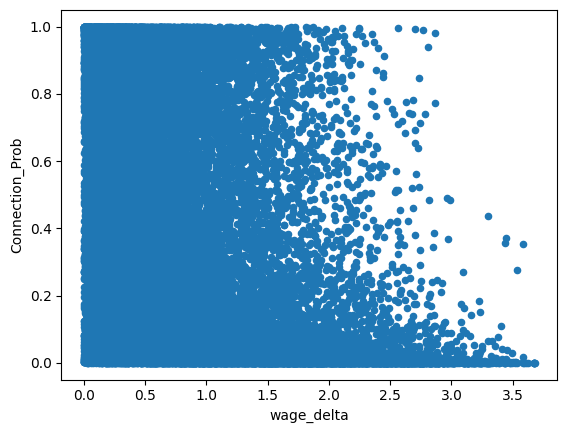

In [356]:
df.boxplot(column = ["Connection_Prob"],
           by = "fellow_country")

df.boxplot(column = ["Connection_Prob"],
           by = "same_title")

df.boxplot(column = ["Connection_Prob"],
           by = "same_experience")

df.plot(kind='scatter',
         x='wage_delta', y="Connection_Prob")


In [360]:
countries = salaries.employee_residence.unique()
color_map = dict(zip(countries,
     np.arange(len(countries))))
country_to_color = lambda x : color_map[x]


G = nx.Graph()
G.add_nodes_from(salaries.index,
                 size = salaries.salary_in_usd)
G.add_edges_from(list(df[df['Connection_Prob'] > 0.9]['idx']))


C:\Users\zogaj\PycharmProjects\MA\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\zogaj\PycharmProjects\MA\venv\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(231, 231)


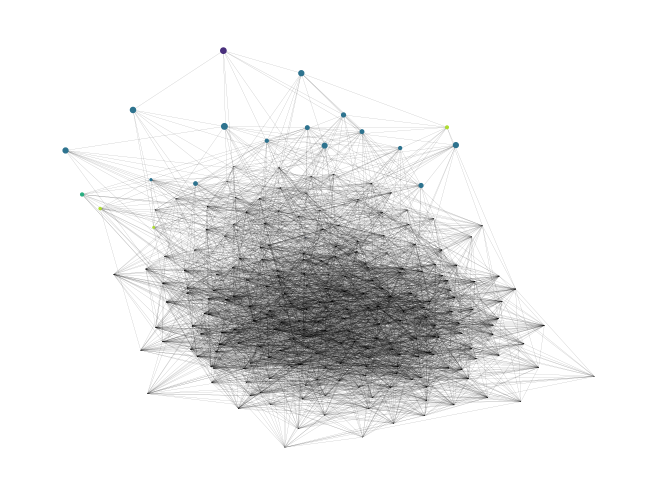

In [364]:
pos = nx.spring_layout(G)
nx.draw(G, with_labels = False, 
        node_size = np.log(salaries.salary_in_usd) * 20,
        pos = nx.spring_layout(G), 
        node_color = salaries.employee_residence.apply(country_to_color), 
        width = 0.05, alpha = 0.99)

print(nx.adjacency_matrix(G).toarray().shape)


In [362]:
mu_y = np.linspace(-10,10,len(countries))  #random.normal(0,6,len(countries))
mu_x = np.linspace(-10,10,len(countries))  #random.normal(0,6, len(countries))

country_centroids = (pd.DataFrame(np.array([countries, mu_x, mu_y]).T).
                     set_index(0).apply(tuple, axis=1).to_dict())


#df.set_index('0').apply(tuple, axis=1).to_dict()

In [363]:
pos
#pos
#{0: np.array([ 0.07516321, -0.18675352]),
# 1: np.array([ 0.87006974, -0.29992044])}


{0: array([-0.18904718, -0.26564907]),
 1: array([-0.9071482,  1.       ]),
 2: array([-0.33145718, -0.04238392]),
 4: array([-0.45745803,  0.11180217]),
 10: array([ 0.34107461, -0.33191763]),
 11: array([ 0.37358483, -0.36073636]),
 12: array([ 0.12143616, -0.42866982]),
 13: array([-0.2974059 ,  0.05272019]),
 16: array([ 0.50374189, -0.03554925]),
 18: array([ 0.59806742, -0.26744244]),
 21: array([ 0.23924486, -0.51844637]),
 22: array([0.39728812, 0.21094517]),
 29: array([0.15808253, 0.44474271]),
 30: array([ 0.01806243, -0.29044292]),
 31: array([-0.35880985, -0.09343404]),
 32: array([-0.09595142, -0.26737743]),
 34: array([ 0.4194994 , -0.32740626]),
 37: array([-0.98017947,  0.58825126]),
 39: array([-0.32957669,  0.19732965]),
 41: array([0.2699459 , 0.27855619]),
 44: array([0.05469304, 0.17856598]),
 45: array([ 0.17039808, -0.71228649]),
 46: array([-0.07194757, -0.02310892]),
 49: array([ 0.08414717, -0.00141182]),
 50: array([ 0.71104454, -0.35294022]),
 55: array([-0